In [94]:
import os.path as path
import pandas as pd
import urllib
import zipfile
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.mlab as mlab
import glob

from scipy.stats.kde import gaussian_kde
%matplotlib inline

from statsmodels.nonparametric.kde import KDEUnivariate

#import statsmodels.api as sm
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import StandardScaler

# Densité

In [95]:
# lecture du fichier
# densité de medecins par region
xl_densite = pd.ExcelFile("Effectif_et_densite_par_region_en_2014.xls")
print(xl_densite.sheet_names)

['Lisez moi', 'Nomenclature des PS', 'Spécialistes', 'Généralistes et MEP', 'Auxiliaires médicaux', 'Sages-femmes', 'Dentistes et ODF', 'Laboratoires']


### Spécialistes

In [96]:
# nettoyage des "spécialistes"
df_spe_densite = xl_densite.parse("Spécialistes")
print(df_spe_densite.head())

df_spe_densite.dtypes
# pas de chgt de type nécessaire

# regarder s'il y a ds valeurs à NaN
if df_spe_densite.isnull().values.any():
    print("NaN")
else:
    print("Pas NaN")
    
# supprimer les lignes 'TOTAL'
specialiste_slicer = df_spe_densite['Spécialistes'].str.upper().str.contains('TOTAL')
region_slicer = df_spe_densite['REGION INSEE'].str.upper().str.contains('TOTAL')
df_spe_densite = df_spe_densite[~specialiste_slicer & ~region_slicer]

df_spe_densite['Spécialistes'].unique()

                              Spécialistes           REGION INSEE  EFFECTIF  \
0  02- Anesthésie-réanimation chirurgicale      11- Ile-de-France       634   
1  02- Anesthésie-réanimation chirurgicale  21- Champagne-Ardenne        66   
2  02- Anesthésie-réanimation chirurgicale           22- Picardie        70   
3  02- Anesthésie-réanimation chirurgicale    23- Haute-Normandie        83   
4  02- Anesthésie-réanimation chirurgicale             24- Centre        91   

   POPULATION FRANCAISE  DENSITE /100 000 hab.  
0            12005077.0               5.281099  
1             1338122.0               4.932286  
2             1927387.0               3.631860  
3             1851909.0               4.481862  
4             2577474.0               3.530588  
Pas NaN


array(['02- Anesthésie-réanimation chirurgicale',
       '20- Réanimation médicale', '03- Pathologie cardio-vasculaire',
       '43- Chirurgie infantile', '44- Chirurgie maxillo-faciale',
       '46- Chirurgie plastique reconstructrice et esthétique',
       '47- Chirurgie thoracique et cardio-vasculaire',
       '48- Chirurgie vasculaire', '49- Chirurgie viscérale et digestive',
       '04- Chirurgie générale', '10- Neurochirurgie',
       '16- Chirurgie urologique',
       '41- Chirurgie orthopédique et traumatologie',
       '05- Dermato-vénéréologie', '72- Médecine nucléaire',
       '74- Oncologie radiothérapique', '76- Radiothérapie',
       '06- Radiodiagnostic et imagerie médicale',
       '70- Gynécologie médicale', '77- Obstétrique',
       '79- Gynécologie obstétrique et gynécologie médicale',
       '07- Gynécologie obstétrique',
       '08- Gastro-entérologie et hépatologie', '71- Hématologie',
       '73- Oncologie médicale', '09- Médecine interne',
       '11- Oto-rhino-

** Quelles sont les régions les plus denses en médecins, toutes spécialités confondues **

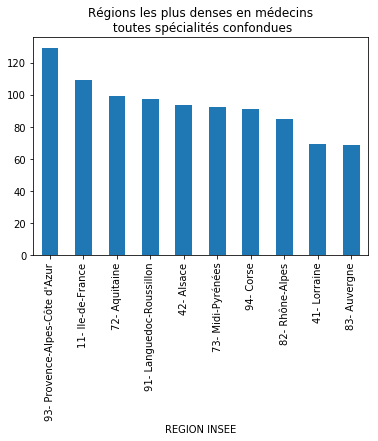

In [97]:
densiteBySpeAndReg = df_spe_densite.groupby(['Spécialistes','REGION INSEE'])['DENSITE /100 000 hab.'].sum()   
#print (densiteBySpeAndReg)
depBySpe = df_spe_densite.groupby(['Spécialistes'])['DENSITE /100 000 hab.'].sum()   

depByReg = df_spe_densite.groupby(['REGION INSEE'])['DENSITE /100 000 hab.'].sum()   
depByReg.sort_values(inplace=True, ascending=False)
depByReg[depByReg != 0][:10].plot.bar(title='Régions les plus denses en médecins\n toutes spécialités confondues')

** PACA **

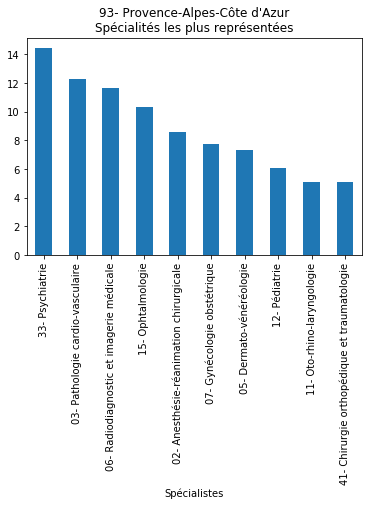

In [98]:
### PACA : spécialités les plus représentées (en densité)

region = "93- Provence-Alpes-Côte d'Azur"
dep_IDF = df_spe_densite[df_spe_densite['REGION INSEE']==region]
#print(dep_IDF)
depBySpeIDF = dep_IDF.groupby(['Spécialistes'])['DENSITE /100 000 hab.'].sum()
depBySpeIDF.sort_values(inplace=True, ascending=False)
depBySpeIDF[depBySpeIDF != 0][:10].plot.bar(title=region+'\nSpécialités les plus représentées')

** Ile de France **

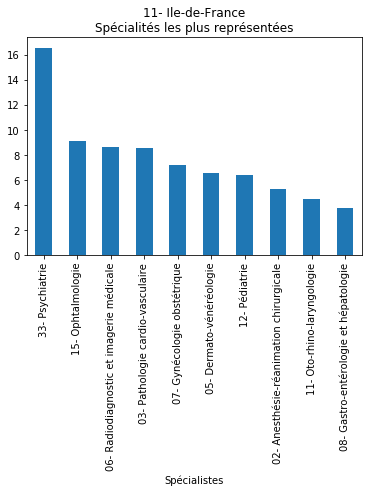

In [99]:
# IDF
region = "11- Ile-de-France"
dep_IDF = df_spe_densite[df_spe_densite['REGION INSEE']==region]
#print(dep_IDF)
depBySpeIDF = dep_IDF.groupby(['Spécialistes'])['DENSITE /100 000 hab.'].sum()
depBySpeIDF.sort_values(inplace=True, ascending=False)
depBySpeIDF[depBySpeIDF != 0][:10].plot.bar(title=region+'\nSpécialités les plus représentées')

** Aquitaine **

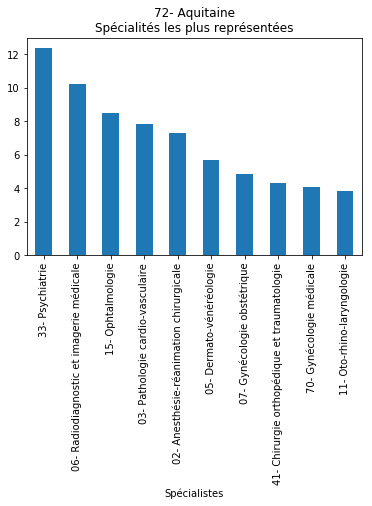

In [100]:
# AQUITAINE
region = "72- Aquitaine"
dep_IDF = df_spe_densite[df_spe_densite['REGION INSEE']==region]
#print(dep_IDF)
depBySpeIDF = dep_IDF.groupby(['Spécialistes'])['DENSITE /100 000 hab.'].sum()
depBySpeIDF.sort_values(inplace=True, ascending=False)
depBySpeIDF[depBySpeIDF != 0][:10].plot.bar(title=region+'\nSpécialités les plus représentées')

** Quelles sont les spécialités les plus représentées, par 100 000 habitants, toutes régions confondues **

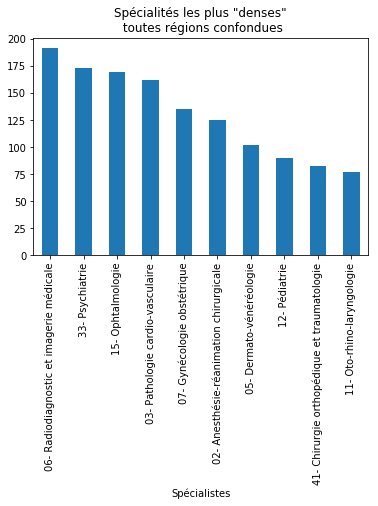

In [101]:
depBySpe = df_spe_densite.groupby(['Spécialistes'])['DENSITE /100 000 hab.'].sum()   
#depBySpe[depBySpe != 0].plot.pie()

depBySpe.sort_values(inplace=True, ascending=False)
depBySpe[depBySpe != 0][:10].plot.bar(title='Spécialités les plus "denses"\n toutes régions confondues')

** Radiologie **

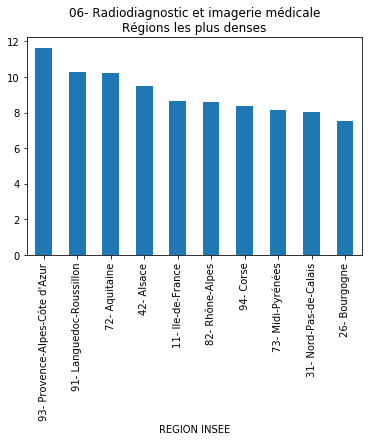

In [102]:
spec = "06- Radiodiagnostic et imagerie médicale"
dep_IDF = df_spe_densite[df_spe_densite['Spécialistes']==spec]
#print(dep_IDF)
depBySpeIDF = dep_IDF.groupby(['REGION INSEE'])['DENSITE /100 000 hab.'].sum()
depBySpeIDF.sort_values(inplace=True, ascending=False)
depBySpeIDF[depBySpeIDF != 0][:10].plot.bar(title=spec+'\nRégions les plus denses')

** Psychiatrie **

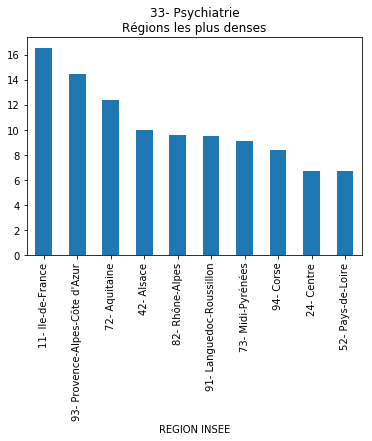

In [103]:
spec = "33- Psychiatrie"
dep_IDF = df_spe_densite[df_spe_densite['Spécialistes']==spec]
#print(dep_IDF)
depBySpeIDF = dep_IDF.groupby(['REGION INSEE'])['DENSITE /100 000 hab.'].sum()
depBySpeIDF.sort_values(inplace=True, ascending=False)
depBySpeIDF[depBySpeIDF != 0][:10].plot.bar(title=spec+'\nRégions les plus denses')

** Ophtalmologie **

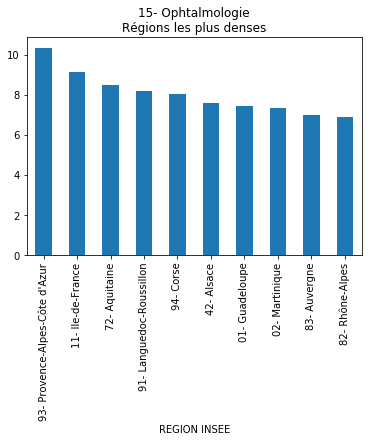

In [104]:
spec = "15- Ophtalmologie"
dep_IDF = df_spe_densite[df_spe_densite['Spécialistes']==spec]
#print(dep_IDF)
depBySpeIDF = dep_IDF.groupby(['REGION INSEE'])['DENSITE /100 000 hab.'].sum()
depBySpeIDF.sort_values(inplace=True, ascending=False)
depBySpeIDF[depBySpeIDF != 0][:10].plot.bar(title=spec+'\nRégions les plus denses')

### Généralistes

In [105]:
df_gen_densite = xl.parse("Généralistes et MEP")
#df_gen_densite.head()

# Honoraires

In [106]:
# lecture du fichier
# Honoraires_totaux_des_professionnels_de_sante_par_region_en_2014
xl = pd.ExcelFile("Honoraires_totaux_des_professionnels_de_sante_par_region_en_2014.xls")
print(xl.sheet_names)

['Lisez moi', 'Nomenclature des PS', 'Spécialistes', 'Généralistes et MEP', 'Dentistes et ODF', 'Sages-femmes', 'Auxiliaires médicaux', 'Laboratoires']


### Spécialistes

In [107]:
# nettoyage des "spécialistes"

df_spe_hono = xl.parse("Spécialistes")
print(df_spe_hono.head())
#print(df_spe_hono.columns)

# typer les colonnes
df_spe_hono.dtypes
df_spe_hono[['HONORAIRES SANS DEPASSEMENT (Euros)','DEPASSEMENTS (Euros)']] = \
    df_spe_hono[['HONORAIRES SANS DEPASSEMENT (Euros)','DEPASSEMENTS (Euros)']].apply(pd.to_numeric, errors='coerce')
#print(df_spe_hono.dtypes)

# remplacer les NaN par 0, dans les colonnes numériques
df_spe_hono[['HONORAIRES SANS DEPASSEMENT (Euros)','DEPASSEMENTS (Euros)']] = \
    df_spe_hono[['HONORAIRES SANS DEPASSEMENT (Euros)','DEPASSEMENTS (Euros)']].fillna(value=0)

# supprimer les lignes 'TOTAL'
specialiste_slicer = df_spe_hono['Spécialistes'].str.upper().str.contains('TOTAL')
region_slicer = df_spe_hono['REGION INSEE'].str.upper().str.contains('TOTAL')
df_spe_hono = df_spe_hono[~specialiste_slicer & ~region_slicer]

# AJouter une colonne depassementUnitaire, qui contient le dépassement moyen par medecin
df_spe_hono['depassementUnitaire'] = df_spe_hono['DEPASSEMENTS (Euros)'] / df_spe_hono['EFFECTIFS']
df_spe_hono[['depassementUnitaire']] = \
    df_spe_hono[['depassementUnitaire']].fillna(value=0)
df_spe_hono['depassementUnitaire'].replace(np.inf, 0, inplace=True)

    
print(df_spe_hono.head())
#print(df_spe_hono[df_spe_hono['EFFECTIFS']==0])
print(df_spe_hono['Spécialistes'].unique())
print(df_spe_hono['REGION INSEE'].unique())

                              Spécialistes           REGION INSEE  EFFECTIFS  \
0  02- Anesthésie-réanimation chirurgicale      11- Ile-de-France        634   
1  02- Anesthésie-réanimation chirurgicale  21- Champagne-Ardenne         66   
2  02- Anesthésie-réanimation chirurgicale           22- Picardie         70   
3  02- Anesthésie-réanimation chirurgicale    23- Haute-Normandie         83   
4  02- Anesthésie-réanimation chirurgicale             24- Centre         91   

  HONORAIRES SANS DEPASSEMENT (Euros) DEPASSEMENTS (Euros)  \
0                           158976164             78534951   
1                            18143039              2331398   
2                            19048276              2962011   
3                            24340405              2486090   
4                            33650792              6570523   

  FRAIS DE DEPLACEMENT (Euros) TOTAL DES HONORAIRES (Euros)  
0                           27                    237511142  
1                     

In [108]:
#print(df_spe_hono[df_spe_hono['EFFECTIFS']==0])

** Régions pratiquant le plus de dépassements, toutes spécialités confondues **

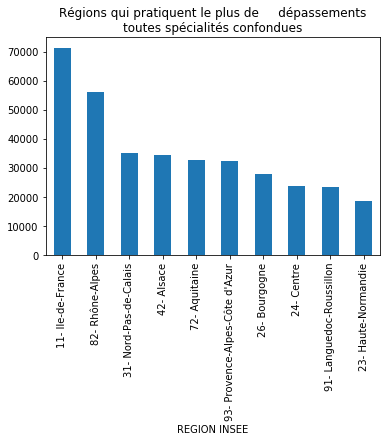

In [109]:
# dépassemnts par specialiste et région
# On plot les régions qui pratiquent le plus de dépassement, toutes spécialités confondues
# on regardera ensuite, pour chacune des trois premières régions, quelles sont les spéciélités
# qui pratiquent le plus de dépassements

depBySpeAndReg = df_spe_hono.groupby(['Spécialistes','REGION INSEE'])['depassementUnitaire'].sum()   
depBySpe = df_spe_hono.groupby(['Spécialistes'])['depassementUnitaire'].mean()   
#depBySpe[depBySpe != 0].plot.pie()

depByReg = df_spe_hono.groupby(['REGION INSEE'])['depassementUnitaire'].mean()   
depByReg.sort_values(inplace=True, ascending=False)
depByReg[depByReg != 0][:10].plot.bar(title='Régions qui pratiquent le plus de \
    dépassements\ntoutes spécialités confondues')

** Ile de France : **

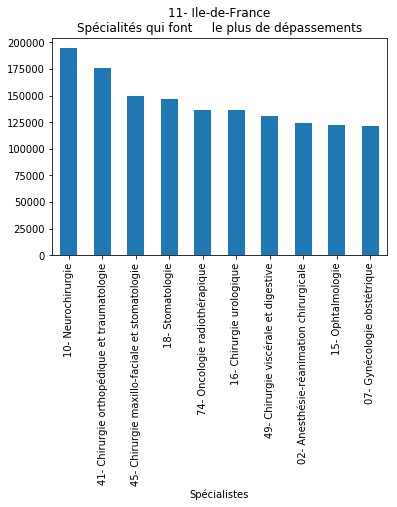

In [110]:
#Ile de France, plot first ten specialities 
region = '11- Ile-de-France'
dep_IDF = df_spe_hono[df_spe_hono['REGION INSEE']==region]
depBySpeIDF = dep_IDF.groupby(['Spécialistes'])['depassementUnitaire'].mean()
depBySpeIDF.sort_values(inplace=True, ascending=False)
depBySpeIDF[depBySpeIDF != 0][:10].plot.bar(title=region+'\nSpécialités qui font \
    le plus de dépassements')

** Rhône Alpes : **

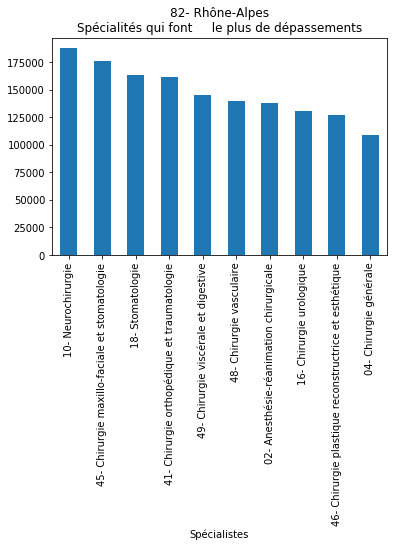

In [111]:
# Rhone Alpes, plot first ten specialities 
region = '82- Rhône-Alpes'
dep_RA = df_spe_hono[df_spe_hono['REGION INSEE']==region]
depBySpeRA = dep_RA.groupby(['Spécialistes'])['depassementUnitaire'].mean()
depBySpeRA.sort_values(inplace=True, ascending=False)
depBySpeRA[depBySpeRA != 0][:10].plot.bar(title=region+'\nSpécialités qui font \
    le plus de dépassements')

** Nord-Pas-de-Calais : **

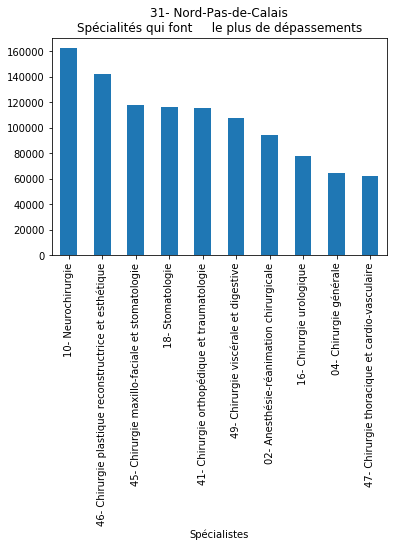

In [112]:
# 31- Nord-Pas-de-Calais plot 10 first specialities
region = "31- Nord-Pas-de-Calais"
dep_P = df_spe_hono[df_spe_hono['REGION INSEE']==region]
depBySpeP = dep_P.groupby(['Spécialistes'])['depassementUnitaire'].mean()
depBySpeP.sort_values(inplace=True, ascending=False)
depBySpeP[depBySpeP != 0][:10].plot.bar(title=region+'\nSpécialités qui font \
    le plus de dépassements')

** Spécialités pratiquant le plus de dépassements, toutes régions confondues **

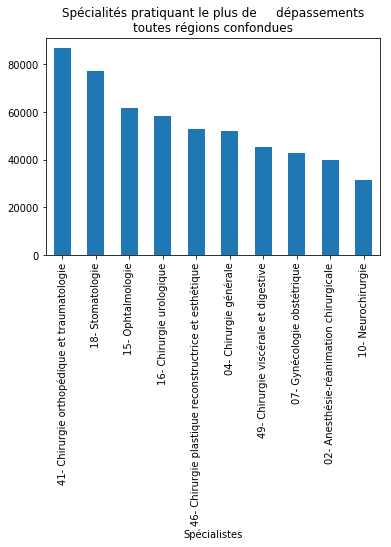

In [113]:
# Spécialités pratiquant le plus de dépassements, toutes régions confondues
depBySpe = df_spe_hono.groupby(['Spécialistes'])['depassementUnitaire'].mean()   
depBySpe.sort_values(inplace=True, ascending=False)
depBySpe[depBySpe != 0][:10].plot.bar(title='Spécialités pratiquant le plus de \
    dépassements\ntoutes régions confondues')

** Chirurgie orthopédique et traumatologie :**

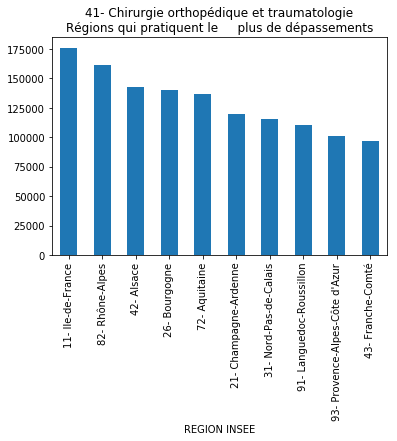

In [114]:
# 41- Chirurgie orthopédique et traumatologie plot 10 first regions
spec = "41- Chirurgie orthopédique et traumatologie"
dep_P = df_spe_hono[df_spe_hono['Spécialistes']==spec]
depBySpeP = dep_P.groupby(['REGION INSEE'])['depassementUnitaire'].mean()
depBySpeP.sort_values(inplace=True, ascending=False)
depBySpeP[depBySpeP != 0][:10].plot.bar(title=spec+'\nRégions qui pratiquent le \
    plus de dépassements')

** Stomatologie :**

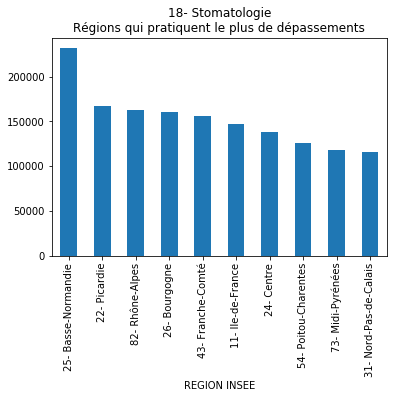

In [115]:
# 18- Stomatologie plot 10 first regions
spec = "18- Stomatologie"
dep_P = df_spe_hono[df_spe_hono['Spécialistes']==spec]
depBySpeP = dep_P.groupby(['REGION INSEE'])['depassementUnitaire'].mean()
depBySpeP.sort_values(inplace=True, ascending=False)
depBySpeP[depBySpeP != 0][:10].plot.bar(title=spec+'\nRégions qui pratiquent le plus de dépassements')

** Ophtalmologie :**

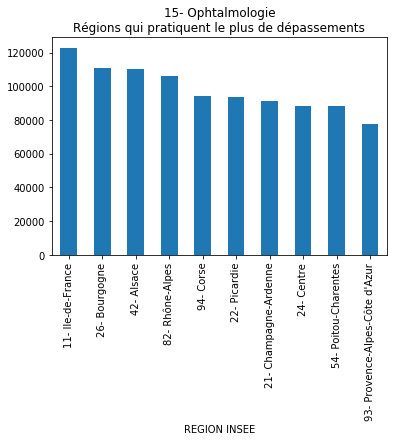

In [116]:
# 15- Ophtalmologie
spec = "15- Ophtalmologie"
dep_P = df_spe_hono[df_spe_hono['Spécialistes']==spec]
depBySpeP = dep_P.groupby(['REGION INSEE'])['depassementUnitaire'].mean()
depBySpeP.sort_values(inplace=True, ascending=False)
depBySpeP[depBySpeP != 0][:10].plot.bar(title=spec+'\nRégions qui pratiquent le plus de dépassements')

### Généralistes

In [117]:
df_gen_hono = xl.parse("Généralistes et MEP")
df_gen_hono.head()
df_gen_hono.columns
df_gen_hono['Généralistes et compétences MEP'].unique()


array(['01- Médecine générale', '01- M.E.P.', '01- OMNIPRATICIENS',
       '01- Acupuncture', '02- Homéopathie',
       '03- Thermalisme (hydrologie, cures climatiques)',
       '04- Allergologie', '05- Angiologie', '06- Médecine physique',
       '07- Phoniatrie', '08- Echotomographie', "09- Médecine d'urgence",
       '10- Médecine Légale', '40- Audiométrie',
       '41- Acupuncture et Médecine Générale',
       '42- Allergologie et Médecine Générale',
       '43- Anesthésie-réanimation', '44- Angiologie et Médecine Générale',
       '45- Biologie', '46- Carcinologie', '47- Cardiologie',
       '48- Chirurgie esthétique', '49- Chirurgie générale',
       '50- Chirurgie maxillo-faciale', '51- Chirurgie vasculaire',
       '52- Dermatologie et maladies vénériennes',
       '53- Electroencéphalographie et électromyographie',
       '54- Electroradiologie', '55- Endocrinologie et métabolisme',
       '56- Gastro-entérologie', '57- Gériatrie', '58- Gynécologie',
       '59- Hématologie', 

# Conclusions

** On constate que la région la plus dense, toutes spécialités confondues, est PACA, et elle n'apparaît pas dans les 3 régions qui 
pratiquent le plus de dépassements **     

** L'île de France, en revanche, région la plus dense, est aussi celle qui pratique en moyenne le plus de dépassement, toutes spécialités confondues.     
En île de France, la spécialité la plus représentée est la psychiatrie, mais ce n'est pas celle qui pratique le plus de dépassement.    
La spécialité qui pratique le plus de dépassement en France, est la chirurgie, mais ce n'est pas la plus dense
**

** Il n'y a pas, selon moi, de corrélation évidente entre la pratique du dépassement, et la densité **


** Remarque : il faudrait ajouter les généralistes dans cette étude
**


In [118]:
import glob
glob.glob("/Users/very/Documents/MP/INFMDI721/marie-ranchet/Lesson5/*.csv")




['/Users/very/Documents/MP/INFMDI721/marie-ranchet/Lesson5/N201707.csv',
 '/Users/very/Documents/MP/INFMDI721/marie-ranchet/Lesson5/rpps-medecins-tab5_50482786525766.csv',
 '/Users/very/Documents/MP/INFMDI721/marie-ranchet/Lesson5/rpps-medecins-tab7_50483002307494.csv']

In [119]:

##df2['DEPARTEMENT'].str.split('-', 1)
#df2['DEPARTEMENT'] = df2['DEPARTEMENT'].str.extract('([\dAB]+)-(.*)')[1]
#df2['SPECIALITE'].str.split('-', 1).str.get(1)

#df2 = df2.dropna(subset = ['CONVENTIONNES'])
